In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import math
import os
from scipy.stats import ks_2samp
from scipy.spatial import cKDTree
from scipy.interpolate import make_interp_spline
from sklearn.neighbors import KernelDensity
import matplotlib.colors as mpc

In [2]:
outdir = 'FigureS13'
if not os.path.exists(outdir):
    os.mkdir(outdir)

## FigureS13_A

In [3]:
obj = sc.read('15DPI_4.h5ad')

In [4]:
def get_cell_center(obj):
    obj = obj.copy()
    coor = pd.DataFrame(obj.uns['Injury_15DPI_C_rep1_FP200000266TR_E6']['seg_cell'].flatten(), columns=['cell'])
    coor = coor[coor['cell'] > 0]
    coor[['x', 'y']] = np.argwhere(obj.uns['Injury_15DPI_C_rep1_FP200000266TR_E6']['seg_cell'] > 0)
    obj.obsm['cell_center'] = coor.groupby('cell').mean().values
    return obj

In [5]:
obj = get_cell_center(obj)
A = obj.obsm['cell_center'][:,0]>=3600
B = (obj.obsm['cell_center'][:,0]<4300)
C = obj.obsm['cell_center'][:,1]>=500
D = (obj.obsm['cell_center'][:,1]<1400)
sub_obj = obj[A&B&C&D]

In [6]:
npy = obj.uns['Injury_15DPI_C_rep1_FP200000266TR_E6']['seg_cell'][3600:4300, 500:1400]

In [7]:
contours = []
for id_ in np.unique(sub_obj.obs['cell_id']):
    if id_ == -1:
        continue
    arr = np.zeros_like(npy, dtype=np.uint8)
    arr[npy==id_] = 255
    contours_, hierarchy = cv2.findContours(arr,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_TC89_L1)
    contours.append(contours_[0])

In [8]:
contours_reaegc = []
contours_ripc1 = []
contours_imn = []
contours_nptxex = []
for ct in ['reaEGC', 'rIPC1', 'IMN', 'nptxEX']:
    ids = sub_obj.obs['cell_id'][sub_obj.obs['Annotation']==ct].tolist()
    arr = np.zeros_like(npy, dtype=np.uint8)
    for id_ in ids:
        arr[npy==id_] = 255
    contours_, hierarchy = cv2.findContours(arr,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_TC89_L1)
    if ct == 'reaEGC':
        contours_reaegc.extend(contours_)
    elif ct == 'rIPC1':
        contours_ripc1.extend(contours_)
    elif ct == 'IMN':
        contours_imn.extend(contours_)
    elif ct == 'nptxEX':
        contours_nptxex.extend(contours_)

In [9]:
arr =  np.zeros((npy.shape[0], npy.shape[1], 4), dtype=np.uint8)
arr = cv2.drawContours(arr,contours,-1,(125, 125, 125, 255), 1)
arr = cv2.drawContours(arr,contours_nptxex,-1,(89, 0, 163, 255), 2)
arr = cv2.drawContours(arr,contours_imn,-1,(191, 131, 137, 255), 2)
arr = cv2.drawContours(arr,contours_ripc1,-1,(44, 97, 232, 255), 2)
arr = cv2.drawContours(arr,contours_reaegc,-1,(0, 9, 186, 255), 2)
cv2.imwrite(os.path.join(outdir, '15dpi_4_contours.png'), arr)

True

In [10]:
df = pd.read_csv('bin1_matrix/15DPI_4.gem.gz', sep='\t')
df['x'] -= df['x'].min()
df['y'] -= df['y'].min()
A = df['x']>=3600
B = df['x']<4300
C = df['y']>=500
D = df['y']<1400
df = df.loc[A&B&C&D, :]
df['x'] -= 3600
df['y'] -= 500

df['x'] = 700 - df['x']
df['y'] = 900 - df['y']
df.head()

,geneID,x,y,MIDCounts
913,AMEX60DD000003,699,240,1
914,AMEX60DD000003,697,757,1
915,AMEX60DD000003,695,538,1
922,AMEX60DD000003,688,468,1
925,AMEX60DD000003,668,291,1


In [11]:
def get_box(rotated_box, img=arr):
    img = img.copy()
    box = cv2.boxPoints(rotated_box)
    box = np.int0(box)
    cv2.drawContours(img, [box], 0, (255, 255, 255), 2)
    
    center, size, angle = rotated_box[0], rotated_box[1], rotated_box[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))
    height, width = img.shape[0], img.shape[1]
    M = cv2.getRotationMatrix2D(center, angle, 1)
    img_rot = cv2.warpAffine(img, M, (width, height))
    img_crop = cv2.getRectSubPix(img_rot, size, center)
    
    return img

In [12]:
def Nrotate(angle, valuex, valuey, pointx, pointy):
    angle = math.radians(angle)
    valuex = np.array(valuex)
    valuey = np.array(valuey)
    nRotatex = (valuex - pointx) * math.cos(angle) - (valuey - pointy) * math.sin(angle) + pointx
    nRotatey = (valuex - pointx) * math.sin(angle) + (valuey - pointy) * math.cos(angle) + pointy
    return nRotatex, nRotatey

In [13]:
def get_rot_y(row, rotated_box):
    x, y = row['y'], row['x']
    (pointx, pointy), (h, w), angle = rotated_box
    x1, y1 = Nrotate(-angle-90, x, y, pointx, pointy)
    x1 = - x1 + pointx + w/2
    y1 = - y1 + pointy + h/2
    if (x1 >= 0) and (x1 < w) and (y1 >= 0) and (y1 < h):
        return y1
    return np.nan

In [14]:
def get_means(df, w=50, h=50,nbins=50):
    r0 = df['new_y']*0.715
    d0 = df['MIDCounts']/(h*0.715)
    bins = np.linspace(0, w*0.715, nbins)
    digitized = np.digitize(r0, bins)
    bin_means = np.array([d0[digitized == i].sum() for i in range(len(bins))])
    bin_means[np.isnan(bin_means)] = 0
    x_smooth = np.linspace(bins.min(), bins[:-1].max(), 300)
    y_smooth = make_interp_spline(bins, bin_means)(x_smooth)
    
    return bin_means, [x_smooth, y_smooth]

In [15]:
def get_density(rotated_box, gene, gene_id=None, df=df, nbins=50):
    if gene_id:
        df = df[df['geneID']==gene_id]
    df['new_y'] = df[['x', 'y']].apply(get_rot_y, axis=1, rotated_box=rotated_box)
    df = df.dropna(axis=0)
    _, (w, h), _ = rotated_box
    bin_means, [x_smooth, y_smooth] = get_means(df, w=w, h=h,nbins=nbins)
    return bin_means, [x_smooth, y_smooth]

True

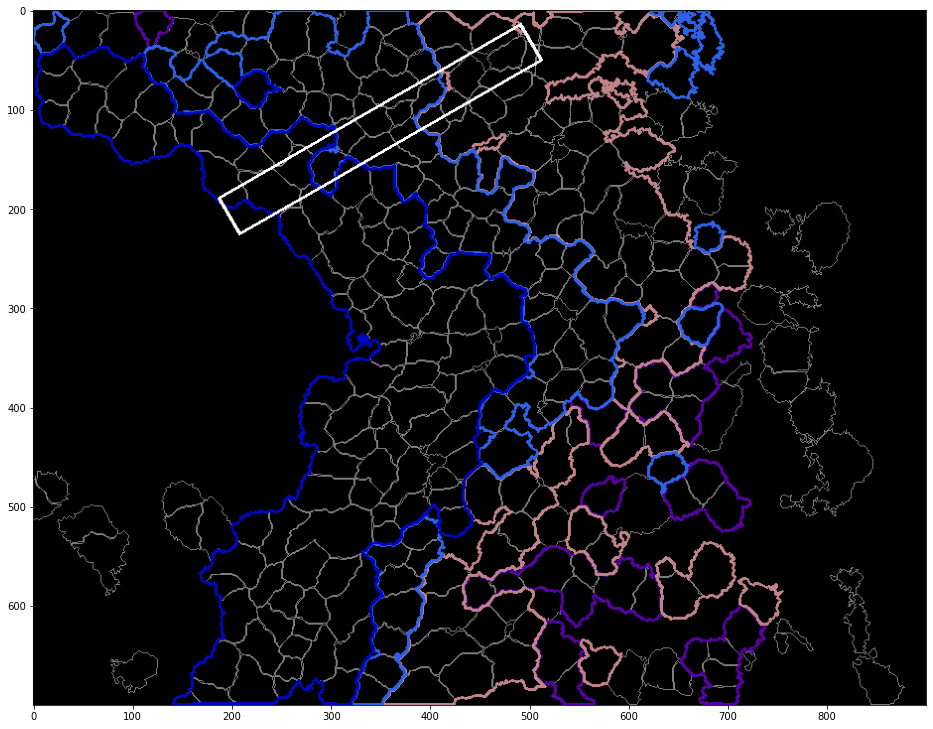

In [16]:
rotated_box = ((350,120),(350,42),-30)
img = arr.copy()
img = np.flipud(np.fliplr(img))
img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
img = get_box(rotated_box, img=img)
plt.figure(figsize=(16, 16))
plt.imshow(img)
cv2.imwrite(os.path.join(outdir, 'rotated_box.png'), img)

## FigureS13_D

In [17]:
genes = {'VIM': 'AMEX60DD022108', 'TNC': 'AMEX60DD050822', 
         'ANKRD1': 'AMEX60DD052557', 'NPTX1': 'AMEX60DD031350'}

In [18]:
vim_means1, vim_smooth1 = get_density(rotated_box,'VIM', genes['VIM'], df = df, nbins=25)
tnc_means1, tnc_smooth1 = get_density(rotated_box,'TNC', genes['TNC'], df = df, nbins=25)
ankrd1_means1, ankrd1_smooth1 = get_density(rotated_box,'ANKRD1', genes['ANKRD1'], df = df, nbins=25)
nptx1_means1, nptx1_smooth1 = get_density(rotated_box,'NPTX1', genes['NPTX1'], df = df, nbins=25)

C:\Users\WANGSH~1\AppData\Local\Temp/ipykernel_18696/3064147037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_y'] = df[['x', 'y']].apply(get_rot_y, axis=1, rotated_box=rotated_box)


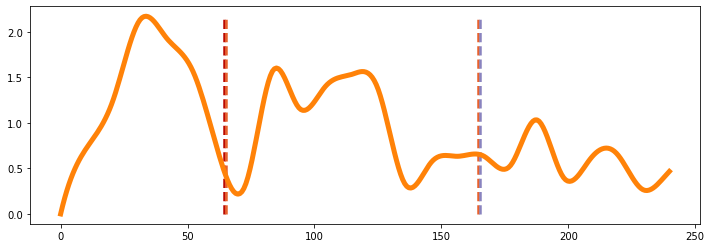

In [19]:
plt.figure(figsize=(12,4))
ymax = vim_smooth1[1].max()
plt.plot(vim_smooth1[0], vim_smooth1[1], linewidth=5,label='VIM', color=mpc.rgb2hex([i/255 for i in (255,130,8)]))
plt.vlines(90*0.715, ymin=0,ymax=ymax, color='#BA0900', linestyle='--', linewidth=2.5)
plt.vlines(90*0.715+.8, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715+.8, ymin=0,ymax=ymax, color='#8983BF', linestyle='--', linewidth=2.5)
plt.savefig(os.path.join(outdir, "15dpi_vim_axis1.pdf"))

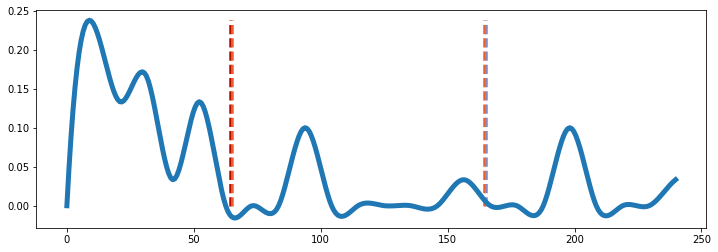

In [20]:
plt.figure(figsize=(12,4))
ymax = tnc_smooth1[1].max()
plt.plot(tnc_smooth1[0], tnc_smooth1[1], linewidth=5, color=mpc.rgb2hex([i/255 for i in (31,119,180)]))
plt.vlines(90*0.715, ymin=0,ymax=ymax, color='#BA0900', linestyle='--', linewidth=2.5)
plt.vlines(90*0.715+.8, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715+.8, ymin=0,ymax=ymax, color='#8983BF', linestyle='--', linewidth=2.5)
plt.savefig(os.path.join(outdir, "15dpi_tnc_axis1.pdf"))

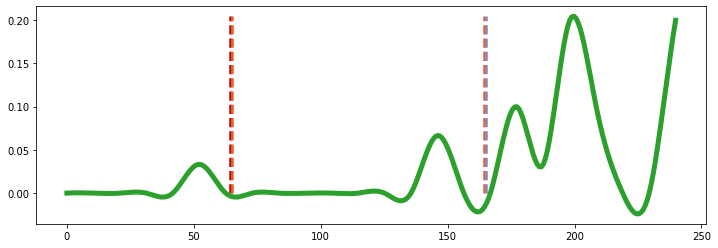

In [21]:
plt.figure(figsize=(12,4))
ymax = ankrd1_smooth1[1].max()
plt.plot(ankrd1_smooth1[0], ankrd1_smooth1[1], linewidth=5, color=mpc.rgb2hex([i/255 for i in (44,160,44)]))
plt.vlines(90*0.715, ymin=0,ymax=ymax, color='#BA0900', linestyle='--', linewidth=2.5)
plt.vlines(90*0.715+.8, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715+.8, ymin=0,ymax=ymax, color='#8983BF', linestyle='--', linewidth=2.5)
plt.savefig(os.path.join(outdir,"15dpi_ankrd1_axis1.pdf"))

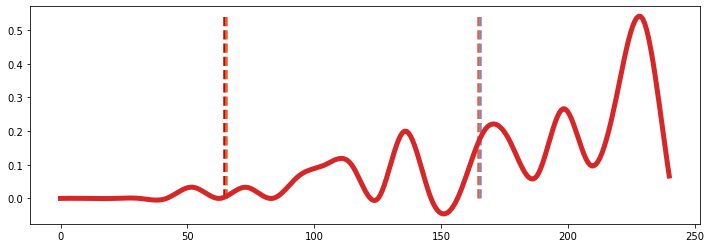

In [22]:
plt.figure(figsize=(12,4))
ymax = nptx1_smooth1[1].max()
plt.plot(nptx1_smooth1[0], nptx1_smooth1[1], linewidth=5, color=mpc.rgb2hex([i/255 for i in (214,39,40)]))
plt.vlines(90*0.715, ymin=0,ymax=ymax, color='#BA0900', linestyle='--', linewidth=2.5)
plt.vlines(90*0.715+.8, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715, ymin=0,ymax=ymax, color='#e8612C', linestyle='--', linewidth=2.5)
plt.vlines(230*0.715+.8, ymin=0,ymax=ymax, color='#8983BF', linestyle='--', linewidth=2.5)
plt.savefig(os.path.join(outdir,"15dpi_nptx1_axis1.pdf"))

## FigureS13_B

In [23]:
def plot_egc_sig(gene, gene_name,colors, labels=['reaEGC', 'rIPC1', 'IMN', 'nptxEX'], obj=obj, k=5, **kwargs):
    data = obj[:, gene].to_df()
    data['A'] = obj.obs['Annotation']
    data = data[data['A'].isin(labels)]
    
    my_type = pd.CategoricalDtype(
      categories=labels,
      ordered=True
    )
    data['A'] = data['A'].astype(my_type)
    fig, ax = plt.subplots(figsize=(8, 12))
    for i in range(len(labels)):
        kwargs['boxprops']['facecolor'] = colors[i]
        kwargs['boxprops']['color'] = colors[i]
        plt.boxplot(data[gene][data['A']==labels[i]], labels=[labels[i]],positions=[i], **kwargs)


    sns.despine(left=True)
    plt.title(f'{gene_name} {gene}')
    plt.ylabel('Expression')

In [24]:
kw = dict(
    notch = False,sym = 'o',
    patch_artist = True,
    boxprops = {'linewidth':3},
    flierprops = {'marker':'o', 'color':'black', 'linewidth':.1},
    medianprops = {'linestyle':'-', 'color':'black', 'linewidth':3},
    whiskerprops = {'linestyle':'--'},
    capprops = {'linewidth':2.5},
    widths=.5,
)

for gene in genes:
    plot_egc_sig(genes[gene],gene, obj=sub_obj,
                 colors=['#BA0900', '#e8612C', '#8983BF', '#A30059', '#666666'], **kw)
    sns.despine(trim=True, left=True)
    plt.savefig(os.path.join(outdir,f'15dpi_c_box_{gene}.pdf'))
    plt.close()

## FigureS13_C

In [25]:
def kde(df, gene, gene_name, l=[5,10,15,20], t=99.99,kernel='tophat'):
    cbs = df.loc[df['geneID']==gene, :]
    for i in l:
        kde = KernelDensity(kernel=kernel, 
                        bandwidth=i).fit(X=cbs[['x', 'y']], 
                                          sample_weight=cbs['MIDCounts'])
        xx, yy = np.mgrid[0:700, 0:900]
        log_d = kde.score_samples(np.vstack([xx.ravel(), yy.ravel()]).T)    
        m = np.exp(log_d.reshape(xx.shape))
        n = m.copy()
        if t < 100:
            m = np.clip(m, m.min(), np.percentile(m, t))
        m -= m.min()
        m /= m.max()
        m = (m*255).astype(np.uint8)
        mm = cv2.applyColorMap(m, cv2.COLORMAP_JET)
        cv2.imwrite(os.path.join(outdir, f'15dpi_4_{kernel}_mm{i}_{gene_name}_{gene}.png'), mm)

In [ ]:
for gene in genes:
    kde(df, genes[gene], gene,l=[5],t=99.98, kernel='tophat')